# Training an Anomalous Jet Detector with **VAE** 

---
In this notebook, we train an unsupervised algorithm capable of compressing a jet features into a low-dimension laten space and, from there, reconstruct the input data. This type of architecture is **autoencoder**:

<img src="https://github.com/saricongi/ML_course_Pavia_23/blob/main_v2/neural-networks/figures/ae.png?raw=1" alt="Drawing" style="width: 600px;"/>

The distance between the input and the output is used to identify rare jets. When trained on background QCD jets (quarks and gluons) it will learn to well reconstruct them yeilding a small reconstruction loss (mean squared error distance) whenever the trained model is evaluated on those. When the trained model sees a different "anomalous" jet it will yield a large loss. Applying a lower treshold on the loss, one can veto standard QCD jets and select a sample enriched in anomalous jets (W, Z, top, etc). 

We will use below a special autoencoder called **variational autoencoder**, which is an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process. Instead of encoding the inputs as a single point, we encode it as a multi-dimensional gaussian distribution over the latent space:

<img src="https://github.com/saricongi/ML_course_Pavia_23/blob/main_v2/neural-networks/figures/vae.png?raw=1" alt="Drawing" style="width: 600px;"/>

The loss is now the sum of two terms:

- the *MSE loss* that makes the encoding-decoding reconstruction scheme as performant as possible
- the *Kullback-Leibler (KL) loss* which represents the distance between gaussian pdfs and acts as a regularization term on the latent space

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

**nb, if you are running locally and you have already downloaded the datasets you can skip the cell below and, if needed, change the paths later to point to the folder with your previous download of the datasets.**

In [2]:
! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz 
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  19.8M      0 --:--:--  0:00:16 --:--:-- 23.6M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [3]:
target = np.array([])
features = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]], dtype=np.float32)
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, features.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 16)


In [4]:
# we standardize the data, so that the mean is = 0 and rms = 1 
from sklearn.preprocessing import StandardScaler
print(np.mean(features[:,10]), np.var(features[:,10]))
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
print(np.mean(features[:,10]), np.var(features[:,10]))

0.089908905 0.001333433
3.7002563e-09 1.0000001


We now separate the dataset in 4:
- a training dataset, consisting of quarks and gluons
- three 'anomalous jets' samples: W, Z, and top

In [5]:
features_standard = features[np.argmax(target,axis=1)<2]
features_W = features[np.argmax(target,axis=1)==2]
features_Z = features[np.argmax(target,axis=1)==3]
features_t = features[np.argmax(target,axis=1)==4]
print(features_standard.shape, features_W.shape, features_Z.shape, features_t.shape)

(19908, 16) (10015, 16) (10037, 16) (10040, 16)


Notice that this is an unsupervised algorithm, so we don't need the target array anymore.
Nevertheless, we keep a part of it around, since it might be useful to test the response 
of the algorithm to quarks and gluons separetly

In [6]:
label_standard = target[np.argmax(target,axis=1)<2]
print(label_standard)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


We now shuffle the standard-jet data and its labels, splitting them into a training, a validation+test dataset with 2:1:1 ratio. 

Then we separate the validation+test in two halves (training and validation)

In [7]:
from sklearn.model_selection import train_test_split

#split into training and test
X_learn, X_test, label_learn, label_test = train_test_split(features_standard, label_standard, test_size=0.2)
print(X_learn.shape, label_learn.shape, X_test.shape, label_test.shape)

#split the training dataset into training and validation
X_train, X_val, label_train, label_val = train_test_split(X_learn, label_learn, test_size=0.2)
print(X_train.shape, label_train.shape, X_val.shape,  label_val.shape, X_test.shape, label_test.shape)

del features_standard, label_standard, features, target, X_learn, label_learn

(15926, 16) (15926, 5) (3982, 16) (3982, 5)
(12740, 16) (12740, 5) (3186, 16) (3186, 5) (3982, 16) (3982, 5)


# Building the VAE model

In [8]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Layer
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [9]:
def sample_z(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    eps = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_var / 2) * eps
#here the loss is different, because is a different problem

Loss definition: The first block of code is just the reconstruction error which is given by the MSE. The second block of code calculates the KL-divergence analytically and adds it to the loss function with the line self.add_loss. It represents the KL-divergence as just another layer in the neural network with the inputs equal to the outputs (means and variances in latent space)

In [10]:
from tensorflow.keras import backend as K

# Define loss
def myloss(y_true, y_pred):
    # mse
    sum_sq = (y_true-y_pred)*(y_true-y_pred)
    return K.sum(sum_sq, axis=-1)

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)
                   #equation in next text 
                   
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

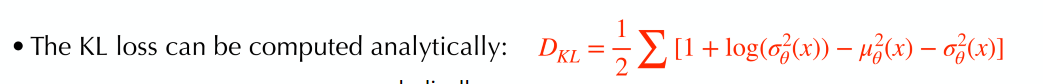

In [11]:
def vae(input_dim, latent_dim, beta):
    #encoder
    input_encoder = Input(shape=(input_dim), name='encoder_input')
    x = Dense(10, activation='elu')(input_encoder)
    z_mu = Dense(latent_dim, name='latent_mu')(x)
    z_log_var = Dense(latent_dim, name='latent_logvar')(x)
    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var]) #we encode in this 
    
    z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_log_var])
    #and now we sample, so z is the output of our encoder
    encoder = Model(inputs=input_encoder, outputs=[z_mu, z_log_var, z], name='encoder')
    encoder.summary()
    
    #decoder
    input_decoder = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(10, activation='elu')(input_decoder)
    dec = Dense(input_dim, activation='linear')(x)    
    decoder = Model(inputs=input_decoder, outputs=dec, name='decoder')
    decoder.summary()
 
    #vae
    vae_outputs = decoder(encoder(input_encoder)[2])
    vae = Model(input_encoder, vae_outputs, name='vae')
    vae.summary()
    
    return vae, encoder

In [12]:
model, encoder = vae(16, 5, 1.0)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 16)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 10)           170         ['encoder_input[0][0]']          
                                                                                                  
 latent_mu (Dense)              (None, 5)            55          ['dense[0][0]']                  
                                                                                                  
 latent_logvar (Dense)          (None, 5)            55          ['dense[0][0]']                  
                                                                                            

In [13]:
model.compile(optimizer='adam', loss=myloss)

In [14]:
n_epochs = 200
batch_size = 128
# train 
history = model.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, X_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
100/100 - 8s - loss: 19.2949 - val_loss: 14.2167 - lr: 0.0010 - 8s/epoch - 78ms/step
Epoch 2/200
100/100 - 0s - loss: 12.5770 - val_loss: 10.9356 - lr: 0.0010 - 409ms/epoch - 4ms/step
Epoch 3/200
100/100 - 0s - loss: 9.9524 - val_loss: 9.1429 - lr: 0.0010 - 417ms/epoch - 4ms/step
Epoch 4/200
100/100 - 1s - loss: 8.7115 - val_loss: 8.2629 - lr: 0.0010 - 610ms/epoch - 6ms/step
Epoch 5/200
100/100 - 1s - loss: 8.0322 - val_loss: 7.8073 - lr: 0.0010 - 670ms/epoch - 7ms/step
Epoch 6/200
100/100 - 1s - loss: 7.5963 - val_loss: 7.4718 - lr: 0.0010 - 690ms/epoch - 7ms/step
Epoch 7/200
100/100 - 0s - loss: 7.3173 - val_loss: 7.2411 - lr: 0.0010 - 500ms/epoch - 5ms/step
Epoch 8/200
100/100 - 0s - loss: 7.1373 - val_loss: 7.0750 - lr: 0.0010 - 417ms/epoch - 4ms/step
Epoch 9/200
100/100 - 0s - loss: 6.9347 - val_loss: 6.8598 - lr: 0.0010 - 408ms/epoch - 4ms/step
Epoch 10/200
100/100 - 0s - loss: 6.8453 - val_loss: 6.7193 - lr: 0.0010 - 395ms/epoch - 4ms/step
Epoch 11/200
100/100 - 0s -

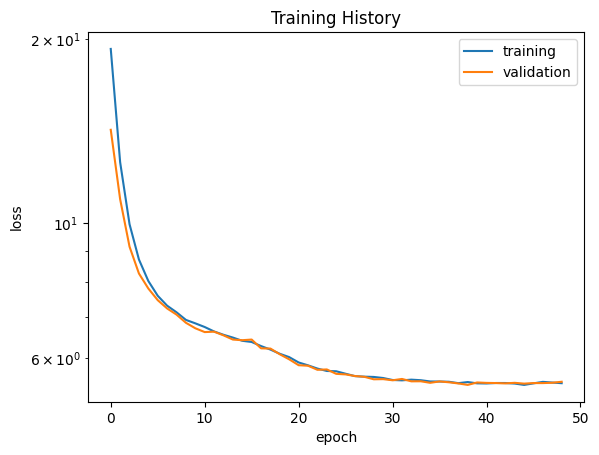

In [15]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Loss Distributions

In [16]:
labels = ['W', 'Z', 'top']

In [17]:
anomaly = [features_W, features_Z, features_t]
predictedQCD = model.predict(X_test)
predicted_anomaly = []
for i in range(len(labels)):
    predicted_anomaly.append(model.predict(anomaly[i]))

314/314 [==============================] - 1s 2ms/step


In [18]:
def mse(data_in, data_out):
    mse = (data_out-data_in)*(data_out-data_in)
    # sum over features
    mse = mse.sum(-1)
    return mse    

In [19]:
lossQCD = mse(X_test, predictedQCD)
loss_anomaly = []
for i in range(len(labels)):
    loss_anomaly.append(mse(anomaly[i], predicted_anomaly[i]))

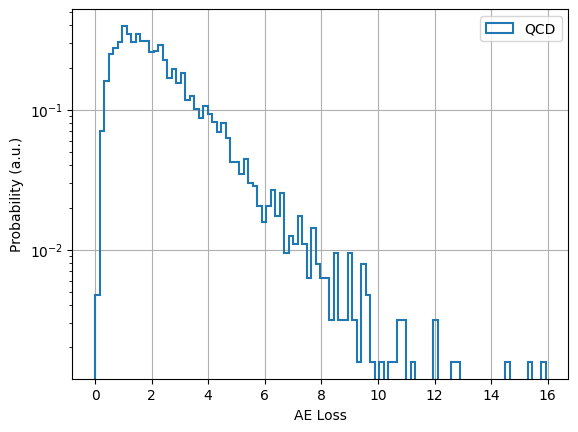

In [20]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

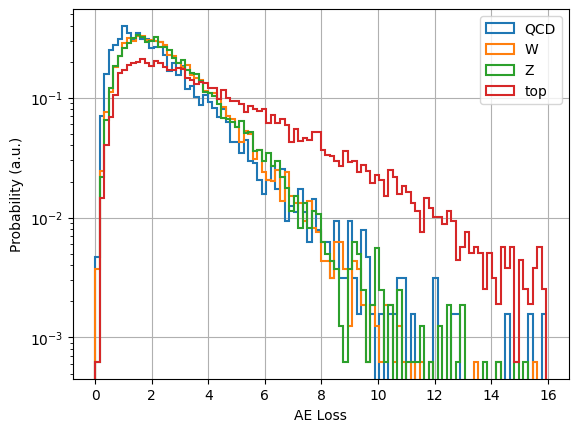

In [21]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
for i in range(len(labels)):
    plt.hist(loss_anomaly[i], bins=100, label=labels[i], density=True, range=(0, maxScore),
            histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Building the ROC Curves

(10015,) (3982,)
(13997,) (13997,)
(10037,) (3982,)
(14019,) (14019,)
(10040,) (3982,)
(14022,) (14022,)


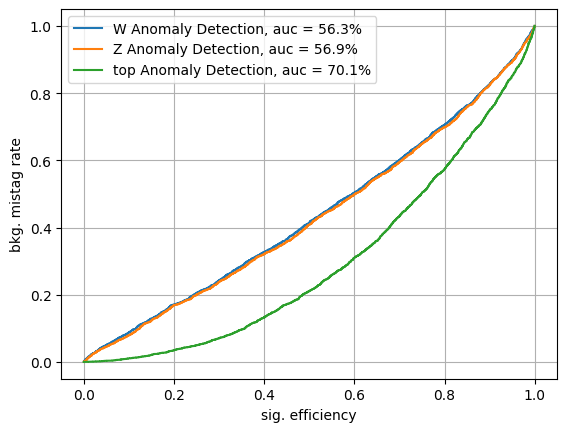

In [22]:
from sklearn.metrics import roc_curve, auc
plt.figure()
targetQCD = np.zeros(lossQCD.shape[0])
for i, label in enumerate(labels):
        print(loss_anomaly[i].shape, targetQCD.shape)
        trueVal = np.concatenate((np.ones(loss_anomaly[i].shape[0]),targetQCD))
        predVal = np.concatenate((loss_anomaly[i],lossQCD))
        print(trueVal.shape, predVal.shape)
        fpr, tpr, threshold = roc_curve(trueVal,predVal)
        auc1= auc(fpr, tpr)
        plt.plot(tpr,fpr,label='%s Anomaly Detection, auc = %.1f%%'%(label,auc1*100.))
#plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()